In [1]:
import pandas as pd
import json
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

In [2]:
fontsize=14
outfolder="plots"

class Category:
    Learned = 0
    Classic = 1
    Perfect = 2
    Other = 3
def category_of(name):
    if name.lower() in {"alex", "pgm", "rmi", "rmicpp", "rmicpprobust", "rs", "ts", "cht"}:
        return Category.Learned
    elif name.lower() in {"btree", "fast", "art", "ibtree"}:
        return Category.Classic
    elif name.lower() in {"mwhc", "sfmwhc", "compactedmwhc", "simplehollowtrie", "hollowtrie"}:
        return Category.Perfect
    else:
        return Category.Other
markers={Category.Learned: "o", Category.Classic: "<", Category.Perfect: "s", Category.Other: "x"}
ignore={"wormhole"}

def map_name(fun):
    if fun.lower() == "ts":
        return "PLEX"
    if fun.lower() == "sfmwhc":
        return "MWHC"
    return fun

color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

In [3]:
df = None #pd.read_csv("name,variant,median_time,byte_size,build_time,searcher,dataset")
for file in os.listdir('./results'):
    if '.csv' not in file: 
        continue
    
    splice = pd.read_csv(f"./results/{file}", names=["name", "variant", "median_time", "byte_size", "build_time", "searcher", "dataset"])
    df = pd.concat([df, splice])

In [4]:
df["mbyte_size"] = df["byte_size"] / 1024**2
df["category"] = df.apply(lambda x : category_of(x["name"]), axis=1)
df = df.sort_values(["category", "byte_size"])

In [5]:
plt1_df = df[df["dataset"].isin(["books_200M_uint64", "fb_200M_uint64", "osm_cellids_200M_uint64", "wiki_ts_200M_uint64"]) & ~(df["category"].isin([Category.Perfect]))].copy(deep=True).reset_index()

plt_outlier1_df = df[df["dataset"].isin(["fb_200M_uint64"]) & df["name"].str.lower().isin({"rs", "ts"})].copy(deep=True).reset_index()
plt_outlier2_df = df[df["dataset"].isin(["fb_200M_uint64"]) & df["name"].str.lower().isin({"rmi", "rmicpp", "rmicpprobust"})].copy(deep=True).reset_index()

plt_rmi_vs_cht_df = df[df["dataset"].isin(["books_200M_uint64", "osm_cellids_200M_uint64"]) & df["name"].str.lower().isin({"rmi", "cht"})].copy(deep=True).reset_index()
plt_rmi_vs_perfect = df[df["dataset"].isin(["books_200M_uint64", "osm_cellids_200M_uint64"]) & df["name"].str.lower().isin({"rmi", "sfmwhc"})].copy(deep=True).reset_index()

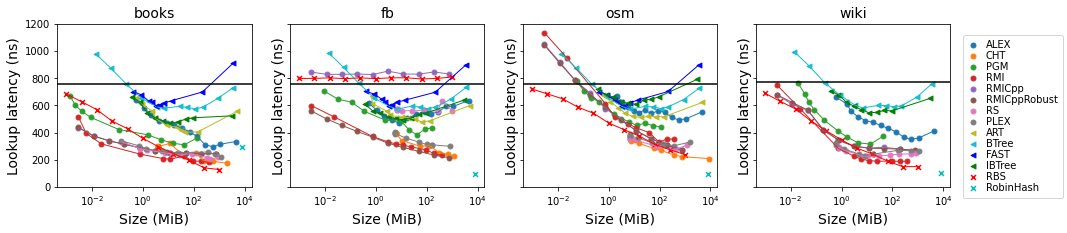

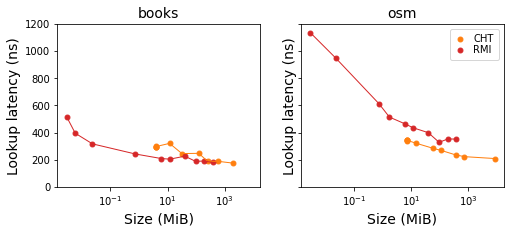

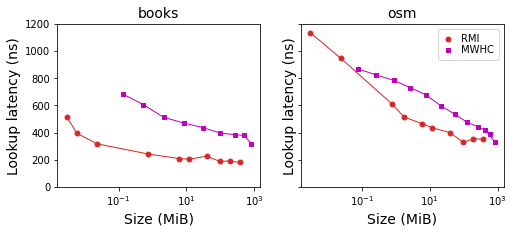

In [8]:
def legend_helper(outside=True):
    def make_legend(fig, axs):
        handles, labels = axs[0].get_legend_handles_labels()
        if outside:
            fig.legend(handles, labels, ncol=1, loc="center right", labelspacing=0.1, borderpad=0.5, handlelength=1)
        else:
            axs[-1].legend(handles, labels, labelspacing=0.1, borderpad=0.5, handlelength=1)
        
    return make_legend

def plt_full(data, outfile, legend=legend_helper(), lims=[0, 1200]):
    datasets = set(data["dataset"])
    fig, axs = plt.subplots(1, len(datasets), figsize=(4 * len(datasets), 3), sharex=True, sharey=True)
    
    for i, (ds, g) in enumerate(data.groupby(["dataset"])):  
        ax = axs[i]
        ax.set_title(ds[:ds.find("_", 0, -1)], fontsize=fontsize)
        ax.set_ylim(lims[0], lims[1])
        ax.set_xscale('log')
        
        for (category, fun), group in g.groupby(["category", "name"]):
            if fun.lower() in ignore:
                continue
            if fun == "BinarySearch":
                ax.axhline(y=list(group["median_time"])[0], color='black', linestyle='-')
                continue
            
            ax.scatter(data=group, x="mbyte_size", y="median_time", label=map_name(fun), marker=markers[category], s=24, color=get_color(fun))
            ax.plot(group["mbyte_size"], group["median_time"], color=get_color(fun), linewidth=1)

        ax.set_xlabel("Size (MiB)", fontsize=fontsize)
        ax.set_ylabel("Lookup latency (ns)", fontsize=fontsize, x=0.05)
    
    legend(fig, axs)
    fig.savefig(f"{outfolder}/{outfile}", bbox_inches="tight", dpi=300)

plt_full(plt1_df, "pareto_full.pdf")
plt_full(plt_rmi_vs_cht_df, "rmi_vs_cht.pdf", legend=legend_helper(False))
plt_full(plt_rmi_vs_perfect, "rmi_vs_perfect.pdf", legend=legend_helper(False))

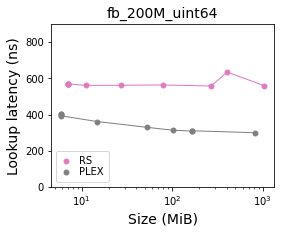

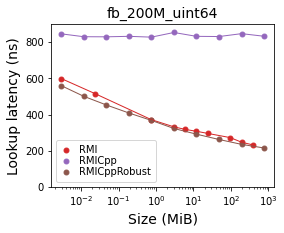

In [7]:
def plt_outlier(data, outfile):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title(set(data["dataset"]).pop(), fontsize=fontsize)
    ax.set_ylim(0, 900)
    ax.set_xscale('log')

    for (category, fun), group in data.groupby(["category", "name"]):
        if fun.lower() in ignore:
            continue
        if fun == "BinarySearch":
            ax.axhline(y=list(group["median_time"])[0], color='black', linestyle='-')
            continue

        ax.scatter(data=group, x="mbyte_size", y="median_time", label=map_name(fun), marker=markers[category], s=24, color=get_color(fun))
        ax.plot(group["mbyte_size"], group["median_time"], color=get_color(fun), linewidth=1)

    ax.set_xlabel("Size (MiB)", fontsize=fontsize)
    ax.set_ylabel("Lookup latency (ns)", fontsize=fontsize, x=0.05)
    ax.legend(loc="lower left", labelspacing=0.1, borderpad=0.5, handlelength=1)
    fig.savefig(f"{outfolder}/{outfile}", bbox_inches="tight", dpi=300)

plt_outlier(plt_outlier1_df, "outlier1.pdf")
plt_outlier(plt_outlier2_df, "outlier2.pdf")